In [125]:
import numpy as np

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def read_all_comm_round_data(comm_round_list, prefix, mid_str, feature_str, final_str, have_label=True, label_str=''):
	all_data = []
	all_label = []
	if (len(comm_round_list) == 1):

		for comm_round_idx in comm_round_list:
			data_name = prefix + feature_str + mid_str + str(comm_round_idx) + final_str
			data = np.load(data_name, allow_pickle=True)
			all_data.append(data)
			label_name = prefix + label_str + mid_str + str(comm_round_idx) + final_str
			label = np.load(label_name)
			all_label.append(label)

		all_data = np.array(all_data)
		all_label = np.array(all_label).flatten()

		return np.squeeze(all_data), np.squeeze(all_label)

num_user = 10
eval_data_size = 1000
num_valid_user = 1
epochs = 1
num_layers = 12
total_data_num = (num_user * 2) * eval_data_size
all_epoch_layer_cos = np.zeros((total_data_num, num_valid_user, 1, num_layers))

final_str = '_96_cifar10_4000_1000_alexnet.npy'
comm_round_list = [0]
prefix = '/content/drive/MyDrive/pycharmPlace/expdata/'
mid_str = '12345_0_client_0_0_10_80_0_0_0_0_0_0_'
data, label = read_all_comm_round_data(comm_round_list, prefix, mid_str,
		                                       feature_str='all_info_multi_party_member_attack_',
		                                       final_str=final_str, label_str='all_label_multi_party_member_attack_')

label = np.reshape(label, (-1))
selected_data = data[:, 3, :]
selected_data[5000:6000,:] = -selected_data[5000:6000, :]
selected_data[1000:2000,:] = -selected_data[1000:2000, :]


In [5]:
import numpy as np

# 通过文件路径加载 .npy 文件
loaded_array = np.load('/content/drive/MyDrive/pycharmPlace/expdata/96gradient.npy', allow_pickle=True)
gradient = []
for i in loaded_array:
  gradient.append(np.linalg.norm(i.flatten()))
print(gradient)


[0.8337739, 1.2502612, 0.60844314, 1.2335507, 1.0841601, 1.2779434, 0.82994217, 0.5169199, 1.2097638, 0.6872404]


In [6]:
def get(list):
  total = []
  user = []
  nonuser = []
  for idx in list:
    x = 0
    y = 0
    for num in list:
      x = x + selected_data[1000*idx:1000*(idx+1),num+1]*gradient[num]
      y = y + selected_data[10000+1000*idx:10000+1000*(idx+1),num+1]*gradient[num]
    user.append(x)
    nonuser.append(y)
  total = np.concatenate((user,nonuser)).flatten()
  return total

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
def get_auc(values):
    # 假设 get(list) 是一个函数来获得相应的评分
    all_scores1 = get(values)
    length = int(len(all_scores1) / 2)
    labels1 = [1] * length + [0] * length
    fpr1, tpr1, thresholds1 = roc_curve(labels1, all_scores1)
    auc1 = roc_auc_score(labels1, all_scores1)
    return [fpr1, tpr1, auc1]


In [8]:
list = [[i] for i in range(10)]
for i in list:
    print(get_auc(i))

0.6465529999999999
0.662897
0.661098
0.519745
0.579502
0.645221
0.665116
0.6796859999999999
0.5074179999999999
0.670743


In [49]:
from itertools import combinations


numbers = [0,1,2,3,4,5, 6, 7, 8, 9]
average_auc_per_length = []

for r in range(1, len(numbers) + 1):
    combinations_r = combinations(numbers, r)
    auc_values = [get_auc(combination)[-1] for combination in combinations_r]
    average_auc = sum(auc for auc in auc_values if auc is not None) / len(auc_values)
    average_auc_per_length.append((r, round(average_auc, 2)))

for combination_length, avg_auc in average_auc_per_length:
    print("Combination length:", combination_length, "Average AUC:", avg_auc)




Combination length: 1 Average AUC: 0.62
Combination length: 2 Average AUC: 0.58
Combination length: 3 Average AUC: 0.56
Combination length: 4 Average AUC: 0.55
Combination length: 5 Average AUC: 0.54
Combination length: 6 Average AUC: 0.53
Combination length: 7 Average AUC: 0.53
Combination length: 8 Average AUC: 0.53
Combination length: 9 Average AUC: 0.53
Combination length: 10 Average AUC: 0.52


In [14]:
from scipy.interpolate import interp1d

def plot_average_roc(curve_data_list):
    # 初始化一个图
    common_x = np.linspace(0, 1, num=100)
    y_values = []

    for curve_data in curve_data_list:

        x, y = curve_data
        x = np.array(x).flatten()
        y = np.array(y).flatten()

        # 使用插值方法将曲线映射到相同的 x 值上
        f = interpolate.interp1d(x, y, kind='linear')
        y_mapped = f(common_x)
        y_values.append(y_mapped)

        # 绘制原始曲线
        #plt.plot(x, y, lw=2, label='ROC curve')

    # 计算平均曲线的数据
    y_avg = np.mean(y_values, axis=0)
    return common_x,y_avg


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d
def get_auc(values):
    # 假设 get(list) 是一个函数来获得相应的评分
    all_scores1 = get(values)
    length = int(len(all_scores1) / 2)
    labels1 = [1] * length + [0] * length
    fpr1, tpr1, thresholds1 = roc_curve(labels1, all_scores1)
    auc1 = roc_auc_score(labels1, all_scores1)
    return [fpr1, tpr1, auc1]

numbers = [0,1,2,3,4,5,6,7,8,9]
#numbers = [0,1,2]
average_auc_per_length = []

plt.figure(figsize=(8, 6))
avg_point = []

for r in range(1, len(numbers) + 1):
    i = r-1
    combinations_r = combinations(numbers, r)
    auc_values = [get_auc(combination) for combination in combinations_r]
    average_auc = sum(auc for _, _, auc in auc_values if auc is not None) / len(auc_values)
    value = np.array(auc_values)
    value = value[:,:2]
    x,y = plot_average_roc(value)
    # 指定不同的颜色和形状
    color = plt.cm.jet(i / len(numbers))  # 使用颜色映射来生成不同颜色

    plt.plot(x, y, color=color,  lw=2, label='Client Number = '+str(r)+', AUC = '+str(round(average_auc,2)))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

plt.show()





<ipython-input-16-33fcb1dc6a2e>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(auc_values)


NameError: ignored

<Figure size 800x600 with 0 Axes>

In [53]:
def get_auc(values):
    # 假设 get(list) 是一个函数来获得相应的评分
    all_scores1 = get(values)
    length = int(len(all_scores1) / 2)
    labels1 = [1] * length + [0] * length
    fpr1, tpr1, thresholds1 = roc_curve(labels1, all_scores1)
    auc1 = roc_auc_score(labels1, all_scores1)
    return [fpr1, tpr1, auc1]

def avg_auc(list):
  score = 0
  number = 0
  for component in list:
    number = number + len(component)
    score = score + get_auc(component)[-1]*len(component)
  score = score/number
  return score

In [18]:

data = [{0, 2, 4, 5, 6, 7}, {3}]

# 将集合转换为列表
data_as_list = [[*i] for i in data]

score = avg_auc(data_as_list)
print(score)

0.5534516666666666


In [69]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

#edge = [9,12,15,20,25]
edge = 15
# 加载邻接矩阵数据
epoch = 5000
distribution = ["poisson","powerlaw"]
adj_matrix_array = np.load("/content/drive/MyDrive/Graph/adj_matrices_"+distribution[0]+"_"+str(epoch)+"_"+str(edge)+"_edge.npy")
numbers = range(1, 10)  # Numbers from 1 to 9

for number in numbers:
    adj_matrix_array_copy = [adj_matrix.copy() for adj_matrix in adj_matrix_array]
    final_residuals = []

    for selected_matrix in adj_matrix_array_copy:
        # 创建图对象
        G = nx.Graph(selected_matrix)

        # 随机选择number个点消去并删除相应的边
        nodes = [*(G.nodes())]
        nodes_to_remove = random.sample(nodes, k=number)
        for node in nodes_to_remove:
            G.remove_node(node)

        # 获取剩下的连通子图
        subgraphs = [*(nx.connected_components(G))]

        # 添加当前图的剩余连通子图结果到最终结果列表
        final_residuals.append(subgraphs)

    scores_array = np.empty(len(final_residuals))

    for i, residual in enumerate(final_residuals):
        data_as_list = [[*i] for i in residual]
        score = avg_auc(data_as_list)  # You need to define avg_auc function
        scores_array[i] = score

    # 将分数数组保存为npy文件
    np.save("/content/drive/MyDrive/Graph/fix"+distribution[0]+"_remove" + str(number) + "_"+str(epoch)+"_edge_"+str(edge)+".npy", scores_array)






import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

#edge = [9,12,15,20,25]
edge = 15
# 加载邻接矩阵数据
epoch = 5000
distribution = ["poisson","powerlaw"]
adj_matrix_array = np.load("/content/drive/MyDrive/Graph/adj_matrices_"+distribution[1]+"_"+str(epoch)+"_"+str(edge)+"_edge.npy")
numbers = range(1, 10)  # Numbers from 1 to 9

for number in numbers:
    adj_matrix_array_copy = [adj_matrix.copy() for adj_matrix in adj_matrix_array]
    final_residuals = []

    for selected_matrix in adj_matrix_array_copy:
        # 创建图对象
        G = nx.Graph(selected_matrix)

        # 随机选择number个点消去并删除相应的边
        nodes = [*(G.nodes())]
        nodes_to_remove = random.sample(nodes, k=number)
        for node in nodes_to_remove:
            G.remove_node(node)

        # 获取剩下的连通子图
        subgraphs = [*(nx.connected_components(G))]

        # 添加当前图的剩余连通子图结果到最终结果列表
        final_residuals.append(subgraphs)

    scores_array = np.empty(len(final_residuals))

    for i, residual in enumerate(final_residuals):
        data_as_list = [[*i] for i in residual]
        score = avg_auc(data_as_list)  # You need to define avg_auc function
        scores_array[i] = score

    # 将分数数组保存为npy文件
    np.save("/content/drive/MyDrive/Graph/fix"+distribution[1]+"_remove" + str(number) + "_"+str(epoch)+"_edge_"+str(edge)+".npy", scores_array)


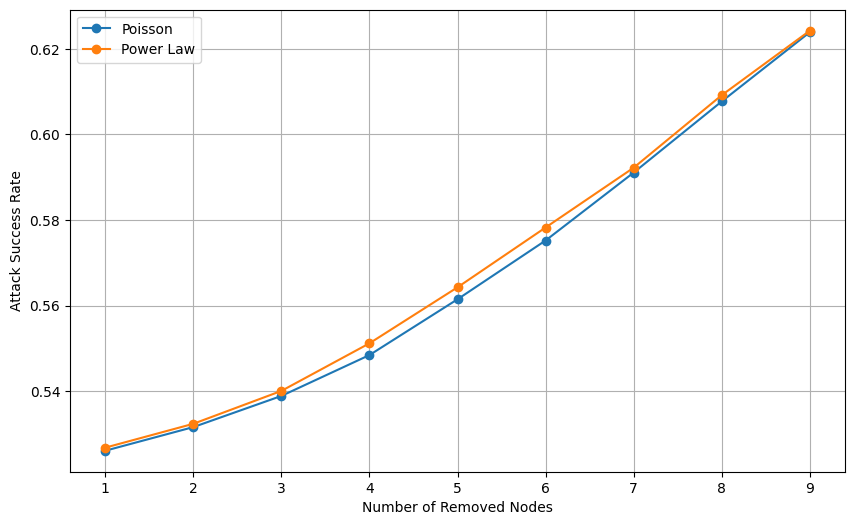

In [2]:
x_poisson = []
y_poisson = []
import numpy as np
edge = 15
epoch = 5000
for i in range(9):
    scores_array = np.load("/content/drive/MyDrive/Graph/fixpoisson_remove" + str(i+1) + "_"+str(epoch)+"_edge_"+str(edge)+".npy")
    average_score = np.mean(scores_array)
    x_poisson.append(i+1)
    y_poisson.append(average_score)

x_powerlaw = []
y_powerlaw = []
for i in range(9):
    scores_array = np.load("/content/drive/MyDrive/Graph/fixpowerlaw_remove" + str(i+1) + "_"+str(epoch)+"_edge_"+str(edge)+".npy")
    average_score = np.mean(scores_array)
    x_powerlaw.append(i+1)
    y_powerlaw.append(average_score)

import numpy as np
import matplotlib.pyplot as plt
# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(x_poisson, y_poisson, marker='o', label='Poisson')
plt.plot(x_powerlaw, y_powerlaw, marker='o', label='Power Law')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Attack Success Rate')
#plt.title('Average AUC with Random Removed Nodes(5000 runs)')
plt.xticks(range(1, 10))
plt.legend()
plt.grid(True)
plt.show()


In [76]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def find_order(adj_matrix):
    G = nx.Graph(adj_matrix)
    num_nodes = G.number_of_nodes()
    list_order = []

    while len(list_order) < num_nodes - 1:
        degrees = [*(G.degree())]
        max_degree = max(degrees, key=lambda x: x[1])[1]
        nodes_with_max_degree = [node for node, degree in degrees if degree == max_degree]

        if len(nodes_with_max_degree) == 1:
            max_degree_node = nodes_with_max_degree[0]
        else:
            max_degree_node = random.choice(nodes_with_max_degree)

        list_order.append(max_degree_node)
        G.remove_node(max_degree_node)

    return list_order

#edge = [9,12,15,20,25]
edge = 15
epoch = 5000
# 加载邻接矩阵数据
distribution = ["poisson","powerlaw"]
adj_matrix_array = np.load("/content/drive/MyDrive/Graph/adj_matrices_"+distribution[0]+"_"+str(epoch)+"_"+str(edge)+"_edge.npy")
numbers = range(1, 10)  # Numbers from 1 to 9
list_poisson = []
for number in numbers:
    adj_matrix_array_copy = [adj_matrix.copy() for adj_matrix in adj_matrix_array]
    final_residuals = []

    for selected_matrix in adj_matrix_array_copy:
        # 创建图对象
        G = nx.Graph(selected_matrix)
        order = find_order(selected_matrix)

        # 选择number个点消去并删除相应的边
        nodes = [*(G.nodes())]
        nodes_to_remove = order[:number]
        for node in nodes_to_remove:
            G.remove_node(node)

        # 获取剩下的连通子图
        subgraphs = [*(nx.connected_components(G))]

        # 添加当前图的剩余连通子图结果到最终结果列表
        final_residuals.append(subgraphs)

    scores_array = np.empty(len(final_residuals))

    for i, residual in enumerate(final_residuals):
        data_as_list = [[*i] for i in residual]
        score = avg_auc(data_as_list)  # You need to define avg_auc function
        scores_array[i] = score

    # 将分数数组保存为npy文件
    np.save("/content/drive/MyDrive/Graph/target"+distribution[0]+"_remove" + str(number) + "_"+str(epoch)+"_edge_"+str(edge)+".npy", scores_array)



import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def find_order(adj_matrix):
    G = nx.Graph(adj_matrix)
    num_nodes = G.number_of_nodes()
    list_order = []

    while len(list_order) < num_nodes - 1:
        degrees = [*(G.degree())]
        max_degree = max(degrees, key=lambda x: x[1])[1]
        nodes_with_max_degree = [node for node, degree in degrees if degree == max_degree]

        if len(nodes_with_max_degree) == 1:
            max_degree_node = nodes_with_max_degree[0]
        else:
            max_degree_node = random.choice(nodes_with_max_degree)

        list_order.append(max_degree_node)
        G.remove_node(max_degree_node)

    return list_order

#edge = [9,12,15,20,25]
edge = 15
epoch = 5000
# 加载邻接矩阵数据
distribution = ["poisson","powerlaw"]
adj_matrix_array = np.load("/content/drive/MyDrive/Graph/adj_matrices_"+distribution[1]+"_"+str(epoch)+"_"+str(edge)+"_edge.npy")
numbers = range(1, 10)  # Numbers from 1 to 9
list_poisson = []
for number in numbers:
    adj_matrix_array_copy = [adj_matrix.copy() for adj_matrix in adj_matrix_array]
    final_residuals = []

    for selected_matrix in adj_matrix_array_copy:
        # 创建图对象
        G = nx.Graph(selected_matrix)
        order = find_order(selected_matrix)

        # 选择number个点消去并删除相应的边
        nodes = [*(G.nodes())]
        nodes_to_remove = order[:number]
        for node in nodes_to_remove:
            G.remove_node(node)

        # 获取剩下的连通子图
        subgraphs = [*(nx.connected_components(G))]

        # 添加当前图的剩余连通子图结果到最终结果列表
        final_residuals.append(subgraphs)

    scores_array = np.empty(len(final_residuals))

    for i, residual in enumerate(final_residuals):
        data_as_list = [[*i] for i in residual]
        score = avg_auc(data_as_list)  # You need to define avg_auc function
        scores_array[i] = score

    # 将分数数组保存为npy文件
    np.save("/content/drive/MyDrive/Graph/target"+distribution[1]+"_remove" + str(number) + "_"+str(epoch)+"_edge_"+str(edge)+".npy", scores_array)





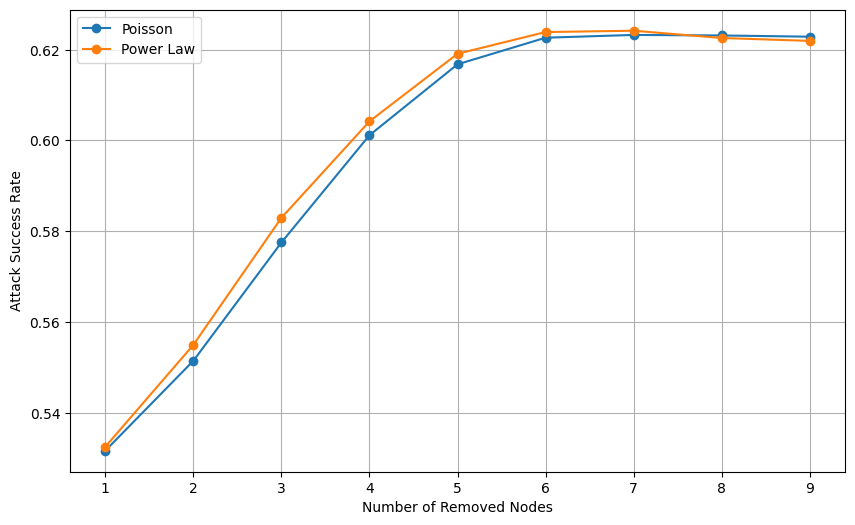

In [3]:
x_poisson = []
y_poisson = []
edge = 15
for i in range(9):
    scores_array = np.load("/content/drive/MyDrive/Graph/targetpoisson_remove" + str(i+1) + "_5000"+"_edge_"+str(edge)+".npy")
    average_score = np.mean(scores_array)
    x_poisson.append(i+1)
    y_poisson.append(average_score)

x_powerlaw = []
y_powerlaw = []
for i in range(9):
    scores_array = np.load("/content/drive/MyDrive/Graph/targetpowerlaw_remove" + str(i+1) +"_5000"+ "_edge_"+str(edge)+".npy")
    average_score = np.mean(scores_array)
    x_powerlaw.append(i+1)
    y_powerlaw.append(average_score)

import numpy as np
import matplotlib.pyplot as plt
# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(x_poisson, y_poisson, marker='o', label='Poisson')
plt.plot(x_powerlaw, y_powerlaw, marker='o', label='Power Law')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Attack Success Rate')
#plt.title('Average AUC with Target Removed Nodes(5000 runs)')
plt.xticks(range(1, 10))
plt.legend()
plt.grid(True)
plt.show()
